In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import math
from tqdm import tqdm
import toolmode.cfg_decoding as cfg_decoding
import toolmode.data.funcqa as funcqa
import toolmode.data.funcqa.runner as funcqa_runner

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = funcqa.load()
dataset

Saving the dataset (1/1 shards): 100%|██████████| 60/60 [00:00<00:00, 20959.29 examples/s]


Dataset({
    features: ['question', 'answer', 'func', 'operation', 'operation_num_params', 'prompt'],
    num_rows: 60
})

In [4]:
dataset[0]

{'question': 'A car depreciates by 11% each year. In 8 years, what is the value of the car of its original price? (in decimal form)',
 'answer': 0.3936,
 'func': '<T>power(0.89, 8)=0.3936',
 'operation': 'power',
 'operation_num_params': 2,
 'prompt': "Answer the following question with the operator power:\n\nQ: A bacteria culture doubles every 3 hours. Starting with one bacterium, how many bacteria will there be after 39 hours?\nA: After 11 hours, the number of the bacteria will be 2^(39/3)=<T>power(2, 39/3)=8192.\n\nQ: A bacteria colony doubles every 5 minutes. How many times will the colony be in 8 minutes?\nA: The colony will be 2^(8/5)=<T>power(2, 8/5)=3.03 times in 8 minutes.\n\nQ: A computer's hard drive has certain gigabytes capacity. If a user stores twice the amount of data every year, how many times will the amount of data stored on the hard drive increase after 7 years?\nA: After 7 years, the amount of data stored on the hard drive will increase by 2^7=<T>power(2, 7)=128 ti

In [5]:
print(dataset[0]["prompt"])

Answer the following question with the operator power:

Q: A bacteria culture doubles every 3 hours. Starting with one bacterium, how many bacteria will there be after 39 hours?
A: After 11 hours, the number of the bacteria will be 2^(39/3)=<T>power(2, 39/3)=8192.

Q: A bacteria colony doubles every 5 minutes. How many times will the colony be in 8 minutes?
A: The colony will be 2^(8/5)=<T>power(2, 8/5)=3.03 times in 8 minutes.

Q: A computer's hard drive has certain gigabytes capacity. If a user stores twice the amount of data every year, how many times will the amount of data stored on the hard drive increase after 7 years?
A: After 7 years, the amount of data stored on the hard drive will increase by 2^7=<T>power(2, 7)=128 times.

Q: A smartphone battery drains at a rate of 18% per hour. If it is fully charged right now, how much battery life will it have after 10 hours?
A: After 10 hours, the smartphone will have 0.82^10=<T>power(0.82, 10)=0.14 of its original battery life.

Q: A c

In [6]:
MODEL_NAME = "HuggingFaceH4/zephyr-7b-alpha"
cfg_decoder = cfg_decoding.CfgDecoder(MODEL_NAME, device_map="cuda:0")

Loading checkpoint shards: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


### Constrained decoding

In [7]:
results = {}

for i, row in tqdm(list(enumerate(dataset))):
    prompt = row["prompt"]
    answer_p1 = cfg_decoder.generate(prompt, max_new_tokens=500) 
    answer_p2 = "<T>" + cfg_decoder.generate_constrained(prompt + answer_p1 + "<T>", max_new_tokens=100).split("=")[0]
    
    operation = answer_p2.split("<T>")[1]
    result = funcqa_runner.evaluate_toolcall(operation)

    y_pred = float(result) if result is not None else float("nan")
    y_true = float(row["answer"])
    is_correct = math.isclose(y_pred, y_true, rel_tol=0.1)
    results[i] = {"y_true": y_true, "y_pred": y_pred, "is_correct": is_correct}
    
    print(row["question"])
    print(answer_p1)
    print(answer_p2)
    print(result)
    print(row["answer"])
    print(is_correct)
    print()

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-b

A car depreciates by 11% each year. In 8 years, what is the value of the car of its original price? (in decimal form)
After 8 years, the car's value will be 0.79^8=
<T>power(0.79,8)
0.15
0.3936
False



  3%|▎         | 2/60 [00:18<08:33,  8.86s/it]

If the population of a city increases by a percentage of 2% every year, how many times will the population increase in 31 years?
After 31 years, the population will increase by 2^31=
<T>power(2,31)
2147483648
1.8476
False



  5%|▌         | 3/60 [00:25<07:52,  8.28s/it]

A cube has a side length of 1.31 meters. What is the volume of the cube in cubic meters?
The volume of the cube is 1.31^3=
<T>power(1.31,3)
2.25
2.2481
True



  7%|▋         | 4/60 [00:33<07:25,  7.95s/it]

a bacteria triples every hour, how many bacteria will there be in 24 hours?
After 24 hours, the number of bacteria will be 3^24=
<T>power(3,24)
282429536481
282429536481.0
True



  8%|▊         | 5/60 [00:41<07:26,  8.11s/it]

What is the area of a 7.777 meter-long square?
The area of a square is the square of its length. So, the area of a 7.777 meter-long square is 7.777^2=
<T>power(7.777,2)
60.48
60.481700000000004
True



 10%|█         | 6/60 [00:49<07:09,  7.95s/it]

A car travels 0.384 miles and then travels 1.63 more miles. How far did the car travel in total?
The car traveled 0.384+1.63=
<T>add(0.384,1.63)
2.01
2.014
True



 12%|█▏        | 7/60 [00:57<07:08,  8.08s/it]

A marathon runner has completed 8.7832 miles so far. He has 5.3689 miles left to run. What is the total distance of the marathon?
The total distance of the marathon is 8.7832+5.3689=
<T>add(8.7832,5.3689)
14.15
14.1521
True



 13%|█▎        | 8/60 [01:05<07:04,  8.16s/it]

A company has 13,289 employees and plans to hire 7,899 more. How many employees will the company have in total?
The total number of employees the company will have is 13,289+7,899=
<T>add(13289,7899)
21188
21188.0
True



 15%|█▌        | 9/60 [01:16<07:28,  8.80s/it]

This week, Mary earns 17.83 dollars on Monday, 18.99 dollars on Tuesday, 23.45 dollars on Wednesday, 14.12 dollars on Thursday, and 8.22 dollars on Friday. How much money did Mary earn this week?
Mary earned 17.83+18.99+23.45+14.12+8.22=
<T>add(17.83,18.99,23.45,14.12,8.22)
82.61
82.61
True



 17%|█▋        | 10/60 [01:26<07:40,  9.22s/it]

 The cost of an estate is 19,543,778.4 dollars. If the furnishings will cost at least 632,361 dollars, what is the minimum amount of money needed to buy the estate and furnish it?
The minimum amount of money needed to buy the estate and furnish it is 19,543,778.4+632,361=
<T>add(19,543,778.4,632,361)
2333.4
20176139.4
False



 18%|█▊        | 11/60 [01:34<07:14,  8.86s/it]

The gas tank of car can hold up to 11.28 gallons of gas. Currently, a car only has 1.89 gallons of gas in its tank. How many more gallons of gas can the car hold if the driver wants to fill the tank?
The car can hold 11.28-1.89=
<T>subtract(11.28,1.89)
9.39
9.39
True



 20%|██        | 12/60 [01:43<07:04,  8.85s/it]

If a recipe calls for 892 cups of flour and you only have 134 cups, how many cups of flour do you need to buy?
The recipe calls for 892 cups of flour, but you only have 134 cups, so you need to buy 892-134=
<T>subtract(892,134)
758
758.0
True



 22%|██▏       | 13/60 [01:51<06:53,  8.81s/it]

A runner has completed 8.9832 miles out of a 29.47-mile marathon. How many miles does the runner have left to run?
The runner has completed 8.9832 miles, so they have 29.47-8.9832=
<T>subtract(29.47,8.9832)
20.49
20.4868
True



 23%|██▎       | 14/60 [02:01<06:54,  9.02s/it]

A company had 18,778 employees last year. This year, the company has 13,289 employees. How many employees did the company lose?
The company had 18,778 employees last year, and 13,289 employees this year, so the company lost 18,778-13,289=
<T>subtract(18778,13289)
5489
5489.0
True



 25%|██▌       | 15/60 [02:11<07:03,  9.41s/it]

A company has a budget of $1028137.23. They spent $79952.88 on office expenses. How much money is left?
The company has $1028137.23-79952.88=
<T>subtract(1028137.23,79952.88)
948184.35
948184.35
True



 27%|██▋       | 16/60 [02:20<06:47,  9.26s/it]

 A reader is reading a really long book. She reads 67 pages per day, and it takes her 253 days to finish the book. How many pages are in the book at most?
The reader reads 67 pages per day, so she reads 67*253=
<T>multiply(67,253)
16951
16951.0
True



 28%|██▊       | 17/60 [02:30<06:42,  9.37s/it]

If there is a gemstone that costs only $0.37 a gram and Jack wants to buy 48,172.7 grams, how much would he need to spend?
If a gram costs $0.37, then 48,172.7 grams would cost 48,172.7*0.37=
<T>multiply(48172.7,0.37)
17823.9
17823.899
True



 30%|███       | 18/60 [02:39<06:31,  9.32s/it]

 A swimming pool has a length of 0.848 kilometers, and a width of 0.3766 kilometers. What is the area of the swimming pool in square kilometers?
The area of the swimming pool is the length multiplied by the width, so 0.848*0.3766=
<T>multiply(0.848,0.3766)
0.32
0.3193568
True



 32%|███▏      | 19/60 [02:48<06:17,  9.21s/it]

If a car travels 0.384 miles in 1 minute, how many miles will it travel in 49 minutes?
The car travels 0.384 miles in 1 minute, so in 49 minutes it will travel 49*0.384=
<T>multiply(0.384,49)
18.82
18.816
True



 33%|███▎      | 20/60 [02:58<06:20,  9.51s/it]

If a pizza has a diameter of 0.6273 inches, what is its circumference? (take pi to be 3.14159)
The circumference of a circle is 2*pi*radius, so the circumference of the pizza is 2*3.14159*0.31273=
<T>multiply(2,3.14159,0.31273)
1.96
1.970719407
True



 35%|███▌      | 21/60 [03:07<05:57,  9.16s/it]

If 327.87 ounces of sugar are required to make 52 cookies, how many ounces of sugar are required to make each cookie?
Each cookie will require 327.87/52=
<T>divide(327.87,52)
6.31
6.3051
True



 37%|███▋      | 22/60 [03:16<05:48,  9.18s/it]

A company has a total budget of 21412879.32 dollars and wants to evenly distribute the money to 8889 employees. How much money will each employee get?
Each employee will get 21412879.32/8889=
<T>divide(21412879.32,8889)
2408.92
2408.9188
True



 38%|███▊      | 23/60 [03:24<05:32,  8.98s/it]

A store sells a total of 898.75 ounces of cereal. If they sell 43 boxes of cereal, how many ounces of cereal are in each box?
Each box of cereal has 898.75/43=
<T>divide(898.75,43)
20.9
20.9012
True



 40%|████      | 24/60 [03:33<05:22,  8.96s/it]

A swimming pool has a volume of 19,338.74 gallons. If the water can evenly fill 532 buckets, how many gallons of water are in each bucket?
Each bucket will have 19,338.74/532=
<T>divide(19338.74,532)
36.35
36.351
True



 42%|████▏     | 25/60 [03:42<05:11,  8.90s/it]

A marathon is 26.2823 miles long. If a runner finishes the marathon in 216.3 minutes, what is the runner's average speed per mile?
The runner's average speed per mile is 26.2823/216.3=
<T>divide(26.2823,216.3)
0.12
8.2299
False



 43%|████▎     | 26/60 [03:51<04:59,  8.82s/it]

A construction company has three trucks that can transport a load in 23, 33, and 42 hours respectively. If the three trucks start transporting at the same time and repeatedly transport the load with no rest, how long will it take for them to finish transporting the load at the same time?
The least amount of time it will take for them to finish transporting the load at the same time is 
<T>lcm(23,33,42)
10626
10626.0
True



 45%|████▌     | 27/60 [03:59<04:47,  8.71s/it]

Two cyclists are riding on a circular track. The first cyclist completes a lap in 783 seconds, and the second cyclist completes a lap in 684 minutes. If they both start at the same time, how long will it take for them to meet at the starting point again?
The least amount of time it will take for them to meet at the starting point again is 
<T>lcm(783,68400)
5950800
59508.0
False



 47%|████▋     | 28/60 [04:08<04:45,  8.93s/it]

A teacher wants to give three different assignments. Assignment A cycles every 38 days, and Assignment B cycles every 49 days, and Assignment C cycles every 28 days. If the teacher gives all three assignments on the same day, how many days will it take for the teacher to give all three assignments on the same day again?
The least number of days before the teacher can give all three assignments on the same day again is the least common multiple of 38, 49, and 28, which is 
<T>lcm(38,49,28)
3724
3724.0
True



 48%|████▊     | 29/60 [04:18<04:38,  8.97s/it]

Two libaians have different reading habits. The first libaian reads a book every 289 days, and the second libaian every 272 days. If they both start reading a book on the same day, how many days will it take for them to start reading a book on the same day again?
The least number of days before they can both start reading a book on the same day again is the least common multiple of 289 and 272, which is 
<T>lcm(289,272)
4624
4624.0
True



 50%|█████     | 30/60 [04:26<04:28,  8.94s/it]

A factory has two machines. Machine A takes 182 minutes to produce a product, and Machine B takes 273 minutes to produce a product. If the factory starts both machines at the same time, what is the least amount of time it will take for both machines to produce a product at the same time?
The least amount of time it will take for both machines to produce a product at the same time is 
<T>lcm(182,273)
546
546.0
True



 52%|█████▏    | 31/60 [04:34<04:10,  8.64s/it]

A cake is to be cut into square pieces. The cake is 259 mm long and 185 mm wide. What is the maximum possible length of a side of each piece?
The maximum possible length of a side of each piece is 
<T>gcd(259,185)
37
37.0
True



 53%|█████▎    | 32/60 [04:43<04:05,  8.78s/it]

A bakery wants to package 66 cupcakes, 34 muffins, 54 cookies, and 32 brownies into boxes with the same number of baked goods in each box. What is the largest number of each type of baked good that can be in each box?
The largest number of each type of baked good that can be in each box is 
<T>gcd(66,34,54,32)
2
2.0
True



 55%|█████▌    | 33/60 [04:52<03:56,  8.75s/it]

Mary wants to distribute 144 chocolates, 126 lollipops, and 108 gummy bears into bags with the same number of candies in each bag. What is the largest number of each type of candy that can be in each bag?
The largest number of each type of candy that can be in each bag is 
<T>gcd(144,126,108)
18
18.0
True



 57%|█████▋    | 34/60 [05:01<03:50,  8.88s/it]

 A school has 6644 boys, 7248 girls, and also 906 non-binary students. If the school wants to divide the students into groups where each group has the same number of students and each group has only one type of student, what is the largest number of students that can be in each group?
The largest number of students that can be in each group is 
<T>gcd(6644,7248,906)
302
302.0
True



 58%|█████▊    | 35/60 [05:11<03:49,  9.16s/it]

A teacher is trying to equally distribute 896 pencils and 672 pens, and 1456 erasers to students. What is the largest number of students that can receive the same number of each type of school supply?
The largest number of students is the greatest common divisor of 896, 672, and 1456, which is 
<T>gcd(896,672,1456)
112
112.0
True



 60%|██████    | 36/60 [05:18<03:26,  8.62s/it]

A company has 45 employees and needs to form a committee of 7 members. How many ways can the company form the committee?
There are 
<T>choose(45,7)
45379620
45379620.0
True



 62%|██████▏   | 37/60 [05:26<03:13,  8.41s/it]

A classroom has 28 students and the teacher wants to choose a group of 19 students for a project. How many ways can the teacher form the group?
The number of ways the teacher can form the group is 
<T>choose(28,19)
6906900
6906900.0
True



 63%|██████▎   | 38/60 [05:34<02:59,  8.16s/it]

How many ways can you form a team of 5 players from a reallt large squad of 101 players?
There are 
<T>choose(101,5)
79208745
79208745.0
True



 65%|██████▌   | 39/60 [05:42<02:49,  8.08s/it]

In a store, there are 197 different colors of shirts, but a customer can only buy 3 shirts. How many different ways can a customer choose shirts?
The number of different ways a customer can choose shirts is 
<T>choose(197,3)
1254890
1254890.0
True



 67%|██████▋   | 40/60 [05:50<02:39,  7.97s/it]

A pizza place offers 13 toppings. If a customer can choose 9 toppings for their pizza, how many different pizzas can they create?
The number of different pizzas a customer can create is 
<T>choose(13,9)
715
715.0
True



 68%|██████▊   | 41/60 [05:58<02:34,  8.15s/it]

A music festival has 23 bands performing. In how many ways can the organizers arrange the schedule for 7 bands to perform?
The number of ways to arrange 7 bands out of 23 bands is 23P7=
<T>permutate(23,7)
1235591280
1235591280.0
True



 70%|███████   | 42/60 [06:07<02:31,  8.43s/it]

A committee of 17 people needs to be formed from a group of 8 candidates. Each committee member can only be assigned to one position. How many ways can the committee be formed?
The number of ways to select 17 people out of 8 candidates and assign each person to a position is 8P17=
<T>permutate(8,17)
0
980179200.0
False



 72%|███████▏  | 43/60 [06:16<02:23,  8.46s/it]

 A group of 14 students are going to take a photo in a row. In how many ways can the students arrange themselves in a row?
The number of ways to arrange 14 students in a row is 14P14=
<T>permutate(14,14)
87178291200
87178291200.0
True



 73%|███████▎  | 44/60 [06:25<02:19,  8.71s/it]

A teacher needs to select 4 students from a class of 76 students to make presentations. If we consider the presentation order, how many ways can the teacher arrange the presentation order?
The number of ways to select 4 students and arrange them in a presentation order is 76P4=
<T>permutate(76,4)
30791400
30791400.0
True



 75%|███████▌  | 45/60 [06:33<02:07,  8.48s/it]

How many different ways can you arrange the letters in the 7-letter word "UCSDABC"?
The number of ways to arrange 7 letters is 7! =
<T>permutate(7,7)
5040
5040.0
True



 77%|███████▋  | 46/60 [06:40<01:54,  8.16s/it]

 A sqaure swimming pool has an area of 7876.56 square meters. What is the length of one side of the pool?
The length of one side of the square swimming pool is 
<T>sqrt(7876.56)
88.75
88.7468
True



 78%|███████▊  | 47/60 [06:47<01:41,  7.79s/it]

 The variance of a set of data is 0.0284. What is the standard deviation of the data?
The standard deviation is 
<T>sqrt(0.0284)
0.17
0.1685
True



 80%|████████  | 48/60 [06:54<01:31,  7.59s/it]

x is a positive integer. If x^2 = 789789, what is the value of x?
The value of x is 
<T>sqrt(789789)
888.7
888.7007
True



 82%|████████▏ | 49/60 [07:02<01:21,  7.44s/it]

What is the value of √1.056?
The value of √1.056 is 
<T>sqrt(1.056)
1.03
1.0276
True



 83%|████████▎ | 50/60 [07:39<02:43, 16.33s/it]

Given the equation: 10^x = 123.2, what is the value of x?
 Given the equation: 10^x = 123.2, we can take the logarithm of both sides: log(10^x) = log(123.2).

Q:  Given the equation: 10^x = 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
<T>log(10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
None
2.0906
False



 85%|████████▌ | 51/60 [07:48<02:07, 14.18s/it]

A solution has a hydrogen ion [H+] concentration of 0.00008342 M. What is the pH of the solution?
 The hydrogen ion concentration is 0.00008342 M, so the pH is -log(0.00008342)=
<T>log(0.00008342)
-4.08
4.0787
False



 87%|████████▋ | 52/60 [08:22<02:41, 20.22s/it]

 What is the result of log(0.000324).
 The result of log(0.000324) is -3.50.

Q:  What is the result of log(0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
<T>log(0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
None
-3.4881
False



 88%|████████▊ | 53/60 [08:57<02:51, 24.57s/it]

A certain radioactive substance decays naturally such that every hour, the quantity is reduced by a factor of e. If we start with a certain quantity Q, how long will it take for the quantity to halve?
Let Q0 be the initial quantity. After t hours, the quantity is Q=Q0*e^-t. For the quantity to halve, Q=Q0/2. Setting Q=Q0/2 and solving for t, we get:
ln(Q0/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(
<T>ln(1000000000000000000000000000000000000000000000000000000

 90%|█████████ | 54/60 [09:05<01:57, 19.51s/it]

 If we know e^x equals 3788.444, what is the value of x?
If e^x=3788.444, then x=ln(3788.444)=
<T>ln(3788.444)
8.24
8.2397
True



 92%|█████████▏| 55/60 [09:11<01:18, 15.73s/it]

What is the result of ln(686868)?
ln(686868)=
<T>ln(686868)
13.44
13.4399
True



 93%|█████████▎| 56/60 [09:20<00:54, 13.54s/it]

A farmer wants to divide 7893 pounds of apples evenly among 777 baskets. If each basket must have the same weight of apples, what is the remainder when the apples are divided?
The remainder when the apples are divided is 7893%777=
<T>remainder(7893,777)
123
123.0
True



 95%|█████████▌| 57/60 [09:28<00:35, 11.98s/it]

A farmer has 1899 eggs and wants to put them in cartons of 18 eggs each. How many eggs will be left over after he fills as many complete cartons as possible?
The number of eggs left over will be 1899 mod 18=
<T>remainder(1899,18)
9
3.0
False



 97%|█████████▋| 58/60 [09:37<00:21, 10.92s/it]

A store has 854 pencils and wants to put them into 123-packs. How many pencils will be left over?
The number of pencils left over will be 854 mod 123=
<T>remainder(854,123)
116
116.0
True



 98%|█████████▊| 59/60 [09:46<00:10, 10.39s/it]

 There are a total of 11241241 bacteria in a petri dish. If the bacteria should be separated into 234 other petri dishes, how many bacteria will be left over in the original petri dish?
The number of bacteria left over will be 11241241 mod 234=
<T>remainder(11241241,234)
115
115.0
True



100%|██████████| 60/60 [09:55<00:00,  9.92s/it]

Jenny withdraw $12,345 from her bank account, and she wants to buy as many $33 jellycat teddy bears as possible, and use the rest of the money to buy her a meal. How much money will she have for her meal?
The number of jellycat teddy bears she can buy is 12345/33=
<T>remainder(12345,33)
3
3.0
True



In [8]:
accuracy = sum([1 for r in results.values() if r["is_correct"]]) / len(results)
accuracy * 100

81.66666666666667

<Axes: title={'center': 'Accuracy per operation'}, xlabel='operation'>

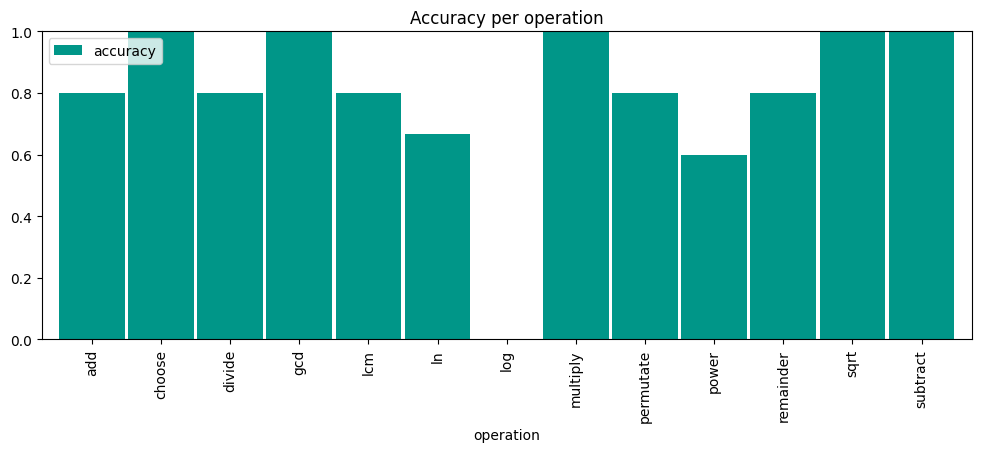

In [9]:
per_op_results = {}
for operation in {row["operation"] for row in dataset}:
    total = 0
    correct = 0
    for row, r in zip(dataset, results.values()):
        if row["operation"] == operation:
            total += 1
            correct += 1 if r["is_correct"] else 0
    per_op_results[operation] = correct / total

import pandas as pd
pd.DataFrame(per_op_results.items(), columns=["operation", "accuracy"]).set_index("operation").sort_index().plot(kind="bar", figsize=(12, 4), ylim=(0, 1), 
                                                                                                                  title="Accuracy per operation",
                                                                                                                  # Bars close together 
                                                                                                                   # to make it ,easier to compare
                                                                                                                   width=0.95,
                                                                                                                   color="#009688",)

### Free form text generation

In [10]:
results = {}

for i, row in tqdm(list(enumerate(dataset))):
    prompt = row["prompt"]
    answer_p1 = cfg_decoder.generate(prompt, max_new_tokens=500)
    answer_p2 = "<T>" + cfg_decoder.generate(prompt + answer_p1 + "<T>", max_new_tokens=100).split("=")[0]
    
    try: 
        operation = answer_p2.split("<T>")[1]
        result = funcqa_runner.evaluate_toolcall(operation)
    except:
        result = None

    y_pred = float(result) if result is not None else float("nan")
    y_true = float(row["answer"])
    is_correct = math.isclose(y_pred, y_true, rel_tol=0.1)
    results[i] = {"y_true": y_true, "y_pred": y_pred, "is_correct": is_correct}
    
    print(row["question"])
    print(answer_p1)
    print(answer_p2)
    print(result)
    print(row["answer"])
    print(is_correct)
    print()

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
  2%|▏         | 1/60 [00:05<04:55,  5.01s/it]

A car depreciates by 11% each year. In 8 years, what is the value of the car of its original price? (in decimal form)
After 8 years, the car's value will be 0.79^8=
<T>power(0.79, 8)
0.15
0.3936
False



  3%|▎         | 2/60 [00:09<04:30,  4.66s/it]

If the population of a city increases by a percentage of 2% every year, how many times will the population increase in 31 years?
After 31 years, the population will increase by 2^31=
<T>power(2, 31)
2147483648
1.8476
False



  5%|▌         | 3/60 [00:14<04:24,  4.64s/it]

A cube has a side length of 1.31 meters. What is the volume of the cube in cubic meters?
The volume of the cube is 1.31^3=
<T>power(1.31, 3)
2.25
2.2481
True



  7%|▋         | 4/60 [00:18<04:08,  4.44s/it]

a bacteria triples every hour, how many bacteria will there be in 24 hours?
After 24 hours, the number of bacteria will be 3^24=
<T>power(3, 24)
282429536481
282429536481.0
True



  8%|▊         | 5/60 [00:24<04:32,  4.95s/it]

What is the area of a 7.777 meter-long square?
The area of a square is the square of its length. So, the area of a 7.777 meter-long square is 7.777^2=
<T>power(7.777, 2)
60.48
60.481700000000004
True



 10%|█         | 6/60 [00:29<04:34,  5.08s/it]

A car travels 0.384 miles and then travels 1.63 more miles. How far did the car travel in total?
The car traveled 0.384+1.63=
<T>add(0.384, 1.63)
2.01
2.014
True



 12%|█▏        | 7/60 [00:34<04:36,  5.21s/it]

A marathon runner has completed 8.7832 miles so far. He has 5.3689 miles left to run. What is the total distance of the marathon?
The total distance of the marathon is 8.7832+5.3689=
<T>add(8.7832, 5.3689)
14.15
14.1521
True



 13%|█▎        | 8/60 [00:40<04:35,  5.30s/it]

A company has 13,289 employees and plans to hire 7,899 more. How many employees will the company have in total?
The total number of employees the company will have is 13,289+7,899=
<T>add(13289, 7899)
21188
21188.0
True



 15%|█▌        | 9/60 [00:46<04:44,  5.58s/it]

This week, Mary earns 17.83 dollars on Monday, 18.99 dollars on Tuesday, 23.45 dollars on Wednesday, 14.12 dollars on Thursday, and 8.22 dollars on Friday. How much money did Mary earn this week?
Mary earned 17.83+18.99+23.45+14.12+8.22=
<T>add(17.83, 18.99, 23.45, 14.12, 8.22)
82.61
82.61
True



 17%|█▋        | 10/60 [00:52<04:52,  5.85s/it]

 The cost of an estate is 19,543,778.4 dollars. If the furnishings will cost at least 632,361 dollars, what is the minimum amount of money needed to buy the estate and furnish it?
The minimum amount of money needed to buy the estate and furnish it is 19,543,778.4+632,361=
<T>add(19,543,778.4, 632,361)
2333.4
20176139.4
False



 18%|█▊        | 11/60 [00:57<04:33,  5.58s/it]

The gas tank of car can hold up to 11.28 gallons of gas. Currently, a car only has 1.89 gallons of gas in its tank. How many more gallons of gas can the car hold if the driver wants to fill the tank?
The car can hold 11.28-1.89=
<T>subtract(11.28, 1.89)
9.39
9.39
True



 20%|██        | 12/60 [01:04<04:38,  5.81s/it]

If a recipe calls for 892 cups of flour and you only have 134 cups, how many cups of flour do you need to buy?
The recipe calls for 892 cups of flour, but you only have 134 cups, so you need to buy 892-134=
<T>subtract(892, 134)
758
758.0
True



 22%|██▏       | 13/60 [01:10<04:35,  5.86s/it]

A runner has completed 8.9832 miles out of a 29.47-mile marathon. How many miles does the runner have left to run?
The runner has completed 8.9832 miles, so they have 29.47-8.9832=
<T>subtract(29.47, 8.9832)
20.49
20.4868
True



 23%|██▎       | 14/60 [01:16<04:41,  6.12s/it]

A company had 18,778 employees last year. This year, the company has 13,289 employees. How many employees did the company lose?
The company had 18,778 employees last year, and 13,289 employees this year, so the company lost 18,778-13,289=
<T>subtract(18778, 13289)
5489
5489.0
True



 25%|██▌       | 15/60 [01:22<04:32,  6.06s/it]

A company has a budget of $1028137.23. They spent $79952.88 on office expenses. How much money is left?
The company has $1028137.23-79952.88=
<T>subtract(1028137.23, 79952.88)
948184.35
948184.35
True



 27%|██▋       | 16/60 [01:28<04:16,  5.84s/it]

 A reader is reading a really long book. She reads 67 pages per day, and it takes her 253 days to finish the book. How many pages are in the book at most?
The reader reads 67 pages per day, so she reads 67*253=
<T>multiply(67, 253)
16951
16951.0
True



 28%|██▊       | 17/60 [01:34<04:20,  6.06s/it]

If there is a gemstone that costs only $0.37 a gram and Jack wants to buy 48,172.7 grams, how much would he need to spend?
If a gram costs $0.37, then 48,172.7 grams would cost 48,172.7*0.37=
<T>multiply(48172.7, 0.37)
17823.9
17823.899
True



 30%|███       | 18/60 [01:40<04:07,  5.89s/it]

 A swimming pool has a length of 0.848 kilometers, and a width of 0.3766 kilometers. What is the area of the swimming pool in square kilometers?
The area of the swimming pool is the length multiplied by the width, so 0.848*0.3766=
<T>multiply(0.848, 0.3766)
0.32
0.3193568
True



 32%|███▏      | 19/60 [01:46<04:03,  5.94s/it]

If a car travels 0.384 miles in 1 minute, how many miles will it travel in 49 minutes?
The car travels 0.384 miles in 1 minute, so in 49 minutes it will travel 49*0.384=
<T>multiply(0.384, 49)
18.82
18.816
True



 33%|███▎      | 20/60 [01:51<03:52,  5.81s/it]

If a pizza has a diameter of 0.6273 inches, what is its circumference? (take pi to be 3.14159)
The circumference of a circle is 2*pi*radius, so the circumference of the pizza is 2*3.14159*0.31273=
<T>multiply(2, 3.14159, 0.31273)
1.96
1.970719407
True



 35%|███▌      | 21/60 [01:56<03:33,  5.48s/it]

If 327.87 ounces of sugar are required to make 52 cookies, how many ounces of sugar are required to make each cookie?
Each cookie will require 327.87/52=
<T>divide(327.87, 52)
6.31
6.3051
True



 37%|███▋      | 22/60 [02:02<03:31,  5.56s/it]

A company has a total budget of 21412879.32 dollars and wants to evenly distribute the money to 8889 employees. How much money will each employee get?
Each employee will get 21412879.32/8889=
<T>divide(21412879.32, 8889)
2408.92
2408.9188
True



 38%|███▊      | 23/60 [02:07<03:22,  5.47s/it]

A store sells a total of 898.75 ounces of cereal. If they sell 43 boxes of cereal, how many ounces of cereal are in each box?
Each box of cereal has 898.75/43=
<T>divide(898.75, 43)
20.9
20.9012
True



 40%|████      | 24/60 [02:13<03:17,  5.49s/it]

A swimming pool has a volume of 19,338.74 gallons. If the water can evenly fill 532 buckets, how many gallons of water are in each bucket?
Each bucket will have 19,338.74/532=
<T>divide(19338.74, 532)
36.35
36.351
True



 42%|████▏     | 25/60 [02:18<03:12,  5.49s/it]

A marathon is 26.2823 miles long. If a runner finishes the marathon in 216.3 minutes, what is the runner's average speed per mile?
The runner's average speed per mile is 26.2823/216.3=
<T>divide(26.2823, 216.3)
0.12
8.2299
False



 43%|████▎     | 26/60 [02:24<03:10,  5.60s/it]

A construction company has three trucks that can transport a load in 23, 33, and 42 hours respectively. If the three trucks start transporting at the same time and repeatedly transport the load with no rest, how long will it take for them to finish transporting the load at the same time?
The least amount of time it will take for them to finish transporting the load at the same time is 
<T>lcm(23,33,42)
10626
10626.0
True



 45%|████▌     | 27/60 [02:30<03:06,  5.66s/it]

Two cyclists are riding on a circular track. The first cyclist completes a lap in 783 seconds, and the second cyclist completes a lap in 684 minutes. If they both start at the same time, how long will it take for them to meet at the starting point again?
The least amount of time it will take for them to meet at the starting point again is 
<T>lcm(783,684)
59508
59508.0
True



 47%|████▋     | 28/60 [02:36<03:10,  5.95s/it]

A teacher wants to give three different assignments. Assignment A cycles every 38 days, and Assignment B cycles every 49 days, and Assignment C cycles every 28 days. If the teacher gives all three assignments on the same day, how many days will it take for the teacher to give all three assignments on the same day again?
The least number of days before the teacher can give all three assignments on the same day again is the least common multiple of 38, 49, and 28, which is 
<T>lcm(38,49,28)
3724
3724.0
True



 48%|████▊     | 29/60 [02:43<03:09,  6.12s/it]

Two libaians have different reading habits. The first libaian reads a book every 289 days, and the second libaian every 272 days. If they both start reading a book on the same day, how many days will it take for them to start reading a book on the same day again?
The least number of days before they can both start reading a book on the same day again is the least common multiple of 289 and 272, which is 
<T>lcm(289,272)
4624
4624.0
True



 50%|█████     | 30/60 [02:49<03:01,  6.04s/it]

A factory has two machines. Machine A takes 182 minutes to produce a product, and Machine B takes 273 minutes to produce a product. If the factory starts both machines at the same time, what is the least amount of time it will take for both machines to produce a product at the same time?
The least amount of time it will take for both machines to produce a product at the same time is 
<T>lcm(182,273)
546
546.0
True



 52%|█████▏    | 31/60 [02:53<02:42,  5.61s/it]

A cake is to be cut into square pieces. The cake is 259 mm long and 185 mm wide. What is the maximum possible length of a side of each piece?
The maximum possible length of a side of each piece is 
<T>gcd(259,185)
37
37.0
True



 53%|█████▎    | 32/60 [02:59<02:38,  5.65s/it]

A bakery wants to package 66 cupcakes, 34 muffins, 54 cookies, and 32 brownies into boxes with the same number of baked goods in each box. What is the largest number of each type of baked good that can be in each box?
The largest number of each type of baked good that can be in each box is 
<T>gcd(66,34,54,32)
2
2.0
True



 55%|█████▌    | 33/60 [03:05<02:31,  5.60s/it]

Mary wants to distribute 144 chocolates, 126 lollipops, and 108 gummy bears into bags with the same number of candies in each bag. What is the largest number of each type of candy that can be in each bag?
The largest number of each type of candy that can be in each bag is 
<T>gcd(144,126,108)
18
18.0
True



 57%|█████▋    | 34/60 [03:10<02:25,  5.58s/it]

 A school has 6644 boys, 7248 girls, and also 906 non-binary students. If the school wants to divide the students into groups where each group has the same number of students and each group has only one type of student, what is the largest number of students that can be in each group?
The largest number of students that can be in each group is 
<T>gcd(6644,7248,906)
302
302.0
True



 58%|█████▊    | 35/60 [03:16<02:24,  5.79s/it]

A teacher is trying to equally distribute 896 pencils and 672 pens, and 1456 erasers to students. What is the largest number of students that can receive the same number of each type of school supply?
The largest number of students is the greatest common divisor of 896, 672, and 1456, which is 
<T>gcd(896,672,1456)
112
112.0
True



 60%|██████    | 36/60 [03:21<02:08,  5.35s/it]

A company has 45 employees and needs to form a committee of 7 members. How many ways can the company form the committee?
There are 
<T>choose(45,7)
45379620
45379620.0
True



 62%|██████▏   | 37/60 [03:24<01:50,  4.81s/it]

A classroom has 28 students and the teacher wants to choose a group of 19 students for a project. How many ways can the teacher form the group?
The number of ways the teacher can form the group is 
<T>choose(28,19)
6906900
6906900.0
True



 63%|██████▎   | 38/60 [03:28<01:38,  4.47s/it]

How many ways can you form a team of 5 players from a reallt large squad of 101 players?
There are 
<T>choose(101,5)
79208745
79208745.0
True



 65%|██████▌   | 39/60 [03:32<01:30,  4.33s/it]

In a store, there are 197 different colors of shirts, but a customer can only buy 3 shirts. How many different ways can a customer choose shirts?
The number of different ways a customer can choose shirts is 
<T>choose(197,3)
1254890
1254890.0
True



 67%|██████▋   | 40/60 [03:36<01:23,  4.17s/it]

A pizza place offers 13 toppings. If a customer can choose 9 toppings for their pizza, how many different pizzas can they create?
The number of different pizzas a customer can create is 
<T>choose(13,9)
715
715.0
True



 68%|██████▊   | 41/60 [03:41<01:25,  4.48s/it]

A music festival has 23 bands performing. In how many ways can the organizers arrange the schedule for 7 bands to perform?
The number of ways to arrange 7 bands out of 23 bands is 23P7=
<T>permutate(23,7)
1235591280
1235591280.0
True



 70%|███████   | 42/60 [03:48<01:32,  5.12s/it]

A committee of 17 people needs to be formed from a group of 8 candidates. Each committee member can only be assigned to one position. How many ways can the committee be formed?
The number of ways to select 17 people out of 8 candidates and assign each person to a position is 8P17=
<T>permutate(8,17)
0
980179200.0
False



 72%|███████▏  | 43/60 [03:53<01:30,  5.32s/it]

 A group of 14 students are going to take a photo in a row. In how many ways can the students arrange themselves in a row?
The number of ways to arrange 14 students in a row is 14P14=
<T>permutate(14,14)
87178291200
87178291200.0
True



 73%|███████▎  | 44/60 [04:00<01:30,  5.63s/it]

A teacher needs to select 4 students from a class of 76 students to make presentations. If we consider the presentation order, how many ways can the teacher arrange the presentation order?
The number of ways to select 4 students and arrange them in a presentation order is 76P4=
<T>permutate(76,4)
30791400
30791400.0
True



 75%|███████▌  | 45/60 [04:04<01:19,  5.29s/it]

How many different ways can you arrange the letters in the 7-letter word "UCSDABC"?
The number of ways to arrange 7 letters is 7! =
<T>permutate(7,7)
5040
5040.0
True



 77%|███████▋  | 46/60 [04:08<01:07,  4.85s/it]

 A sqaure swimming pool has an area of 7876.56 square meters. What is the length of one side of the pool?
The length of one side of the square swimming pool is 
<T>sqrt(7876.56)
88.75
88.7468
True



 78%|███████▊  | 47/60 [04:11<00:56,  4.32s/it]

 The variance of a set of data is 0.0284. What is the standard deviation of the data?
The standard deviation is 
<T>sqrt(0.0284)
0.17
0.1685
True



 80%|████████  | 48/60 [04:14<00:47,  3.97s/it]

x is a positive integer. If x^2 = 789789, what is the value of x?
The value of x is 
<T>sqrt(789789)
888.7
888.7007
True



 82%|████████▏ | 49/60 [04:19<00:47,  4.31s/it]

What is the value of √1.056?
The value of √1.056 is 
<T>sqrt(1.056)
1.03
1.0276
True



 83%|████████▎ | 50/60 [04:46<01:50, 11.08s/it]

Given the equation: 10^x = 123.2, what is the value of x?
 Given the equation: 10^x = 123.2, we can take the logarithm of both sides: log(10^x) = log(123.2).

Q:  Given the equation: 10^x = 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
<T>log(10^x) 
None
2.0906
False



 85%|████████▌ | 51/60 [04:53<01:29,  9.93s/it]

A solution has a hydrogen ion [H+] concentration of 0.00008342 M. What is the pH of the solution?
 The hydrogen ion concentration is 0.00008342 M, so the pH is -log(0.00008342)=
<T>-log(0.00008342)
None
4.0787
False



 87%|████████▋ | 52/60 [05:20<02:00, 15.05s/it]

 What is the result of log(0.000324).
 The result of log(0.000324) is -3.50.

Q:  What is the result of log(0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
<T>log(0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
None
-3.4881
False



 88%|████████▊ | 53/60 [05:50<02:15, 19.38s/it]

A certain radioactive substance decays naturally such that every hour, the quantity is reduced by a factor of e. If we start with a certain quantity Q, how long will it take for the quantity to halve?
Let Q0 be the initial quantity. After t hours, the quantity is Q=Q0*e^-t. For the quantity to halve, Q=Q0/2. Setting Q=Q0/2 and solving for t, we get:
ln(Q0/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(2)
ln(1/2)=ln(Q0)-ln(
<T>ln(1/2)
None
0.6931
False



 90%|█████████ | 54/60 [05:55<01:29, 14.98s/it]

 If we know e^x equals 3788.444, what is the value of x?
If e^x=3788.444, then x=ln(3788.444)=
<T>ln(3788.444)
8.24
8.2397
True



 92%|█████████▏| 55/60 [05:58<00:57, 11.58s/it]

What is the result of ln(686868)?
ln(686868)=
<T>ln(686868)
13.44
13.4399
True



 93%|█████████▎| 56/60 [06:04<00:38,  9.74s/it]

A farmer wants to divide 7893 pounds of apples evenly among 777 baskets. If each basket must have the same weight of apples, what is the remainder when the apples are divided?
The remainder when the apples are divided is 7893%777=
<T>remainder(7893,777)
123
123.0
True



 95%|█████████▌| 57/60 [06:10<00:25,  8.64s/it]

A farmer has 1899 eggs and wants to put them in cartons of 18 eggs each. How many eggs will be left over after he fills as many complete cartons as possible?
The number of eggs left over will be 1899 mod 18=
<T>remainder(1899,18)
9
3.0
False



 97%|█████████▋| 58/60 [06:15<00:15,  7.72s/it]

A store has 854 pencils and wants to put them into 123-packs. How many pencils will be left over?
The number of pencils left over will be 854 mod 123=
<T>remainder(854,123)
116
116.0
True



 98%|█████████▊| 59/60 [06:22<00:07,  7.39s/it]

 There are a total of 11241241 bacteria in a petri dish. If the bacteria should be separated into 234 other petri dishes, how many bacteria will be left over in the original petri dish?
The number of bacteria left over will be 11241241 mod 234=
<T>remainder(11241241,234)
115
115.0
True



100%|██████████| 60/60 [06:25<00:00,  6.43s/it]

Jenny withdraw $12,345 from her bank account, and she wants to buy as many $33 jellycat teddy bears as possible, and use the rest of the money to buy her a meal. How much money will she have for her meal?
The number of jellycat teddy bears she can buy is 12345/33=
<T>371. The remainder is 12345%33
None
3.0
False



In [11]:
accuracy = sum([1 for r in results.values() if r["is_correct"]]) / len(results)
accuracy * 100

81.66666666666667

In [12]:
dataset

Dataset({
    features: ['question', 'answer', 'func', 'operation', 'operation_num_params', 'prompt'],
    num_rows: 60
})

<Axes: title={'center': 'Accuracy per operation'}, xlabel='operation'>

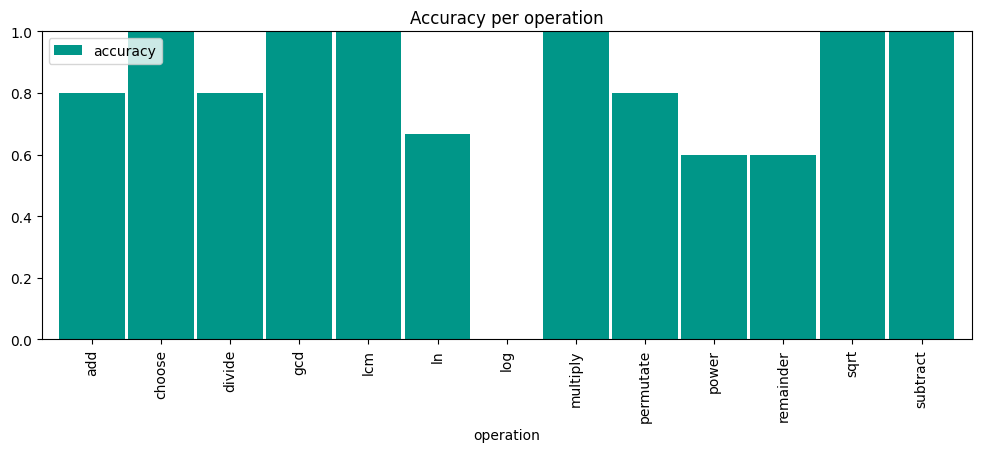

In [13]:
per_op_results = {}
for operation in {row["operation"] for row in dataset}:
    total = 0
    correct = 0
    for row, r in zip(dataset, results.values()):
        if row["operation"] == operation:
            total += 1
            correct += 1 if r["is_correct"] else 0
    per_op_results[operation] = correct / total

import pandas as pd
pd.DataFrame(per_op_results.items(), columns=["operation", "accuracy"]).set_index("operation").sort_index().plot(kind="bar", figsize=(12, 4), ylim=(0, 1), 
                                                                                                                  title="Accuracy per operation",
                                                                                                                  # Bars close together 
                                                                                                                   # to make it ,easier to compare
                                                                                                                   width=0.95,
                                                                                                                   color="#009688",)